Initial try at loading in all available data from the MET132 cruise, and determining horizontal and vertical buoyancy frequency, Richardson numbers and instabilities. 
Included are data from CTD/LADCP stations, and two transects of the Scanfish (towed undulating vehicle) combined with shipboard ADCP data (SADCP).
See MET132_Paper_Layout for a cleaner version of this code, that attempts to layout a potential paper, but only shows Scanfish/SADCP data

In [1]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import urllib.request
import xarray as xr
import pandas as pd
import glob
import os
from datetime import datetime
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from oceans.datasets import etopo_subset
from oceans.sw_extras import gamma_GP_from_SP_pt
from matplotlib.patches import Polygon
import gsw
from matplotlib import animation, rc
from IPython.display import HTML
import scipy.io

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files") # need to set working directory to get the next step to work
from Benguela.src.met132_ctd_ladcp_functions import load_combine_ladcp_ctd_data #import load_ctd_data
from Benguela.src.met132_scanfish_sadcp_functions import load_combine_sadcp_scanfish_data #import load_ctd_data
import Benguela.src.met132_plotting_functions as fg

Load data

In [2]:
filenames = ["/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/SADCP/met_132_os75nb.nc", 
             "/Users/North/Documents/temp_offline_backups/mmap/etopo1/etopo1_namibia_coast.nc",
             "/Volumes/ExtraBackup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016333.L3m_DAY_SST_sst_4km.nc",
             "/Volumes/ExtraBackup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016329.L3m_DAY_SST_sst_4km.nc",
             "/Volumes/ExtraBackup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016324.L3m_DAY_SST_sst_4km.nc",
             "/Volumes/ExtraBackup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/nrt_global_allsat_msla_h_20161128_20161128.nc",
             "/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/Gliders/sebastian_gps_data.mat"]

# load bathymetry
topo = xr.open_dataset(filenames[1])

# load SST map
sst_map = xr.open_dataset(filenames[4]) # lat,lon,sst
sst_map1 = xr.open_dataset(filenames[3]) # lat,lon,sst

# load SSH map
ssh_map = xr.open_dataset(filenames[5]) # lat,lon,sst

# load glider track
# Load in file and call it mat
mat = scipy.io.loadmat(filenames[6])
# check what variables are there (in the dictionary):
#mat.keys()

# Convert time axis to date form:
date_t = [datetime.utcfromtimestamp(i) for i in mat['t'][0,:]]

glider_track = xr.DataArray(np.append(mat['lon'],mat['lat'],axis=0),coords=[('lon_lat',['lon','lat']), ('time', date_t)])


In [3]:
# load SADCP and Scanfish data
pathScanData = r'/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/Scanfish/'   
fileSADCPdata = r'/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/SADCP/met_132_os75nb.nc'
scan_sadcp, scanfish, sadcp = load_combine_sadcp_scanfish_data(fileSADCPdata,pathScanData,grid_dx=750,grid_dz=5)

In [4]:
# load CTD and LADCP data
pathCTDdata = r'/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/CTD_calibrated/Down_Casts/1db_mean/data/'                     # use your path
pathLADCPdata = r'/Users/North/Drive/Work/UniH_Work/DataAnalysis/Data/MET_132/LADCP/profiles/'                     # use your path

ctd_ladcp, ctd, ladcp = load_combine_ladcp_ctd_data(pathLADCPdata, pathCTDdata)


Movie of ship track to determine where overlapping sections of CTD/LADCP stations occur.
The track is shown as a line, and the CTD/LADCP stations are colors. 
Takes a while to load. 

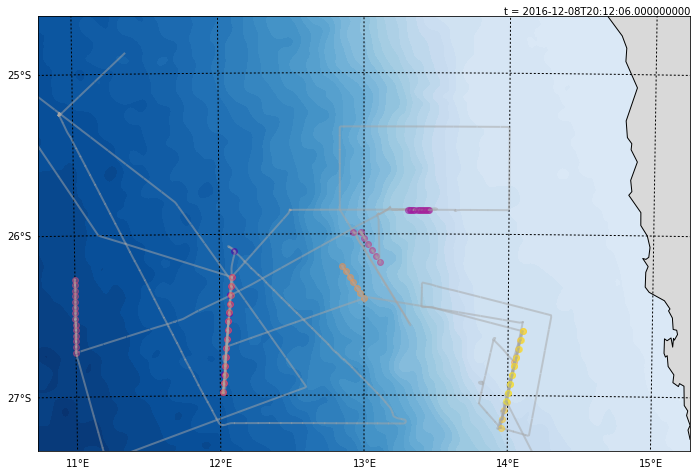

In [5]:
anim1 = fg.make_movie_ship_tracks(topo,sadcp,ladcp)
HTML(anim1.to_html5_video()) 

Plotting transects near Drifter releases

In [6]:
# plot settings
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)


Sections near 1st Drifter station in the filament; not variable subscripts for LADCP vs SADCP data. The T,S,Rho data corresponding to the SADCP data comes from the Scanfish, after gridding it in "load_combine_sadcp_scanfish_data"

/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)
/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


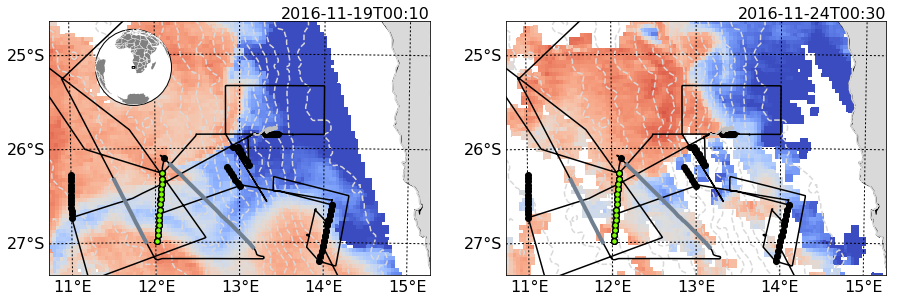

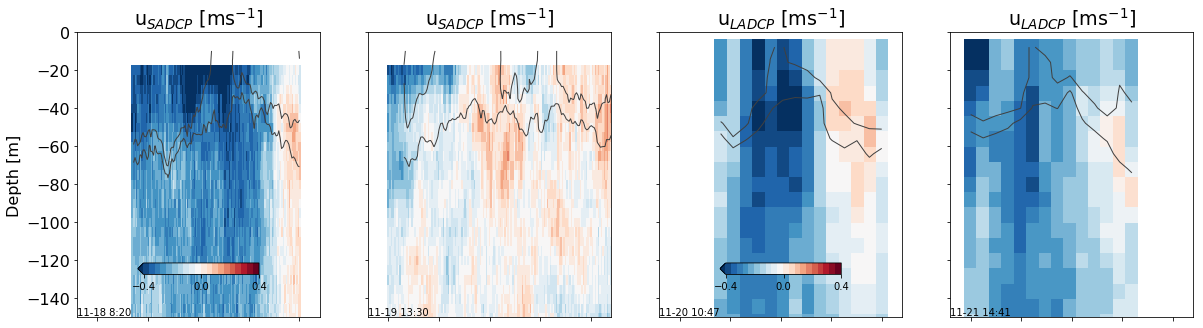

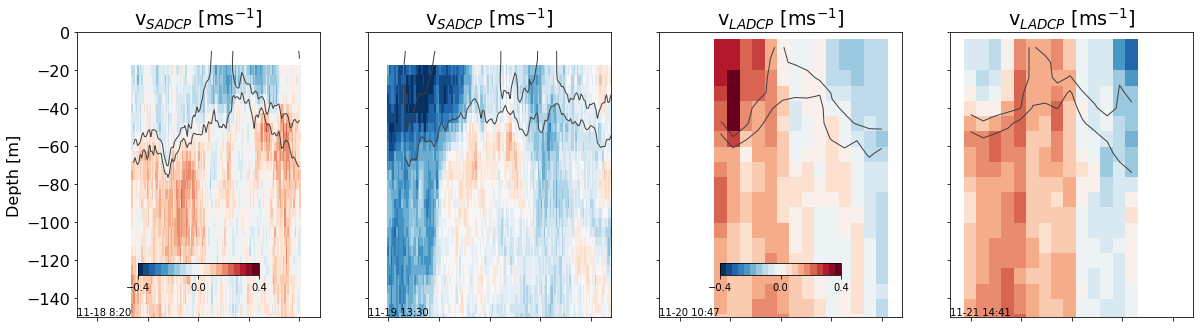

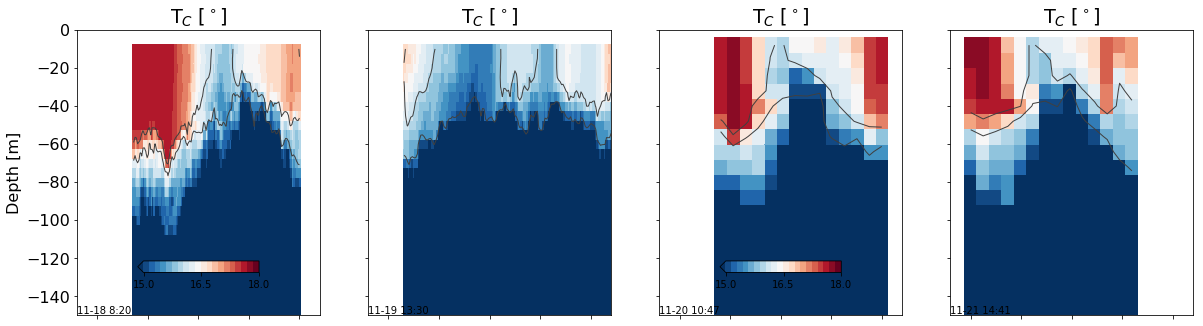

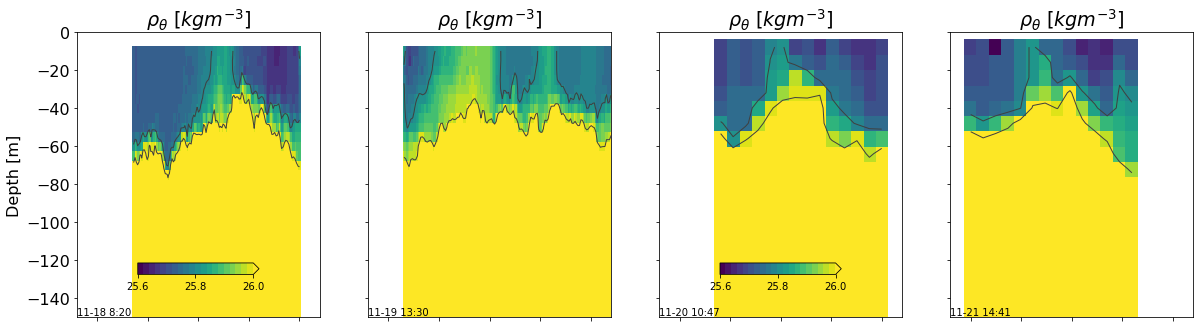

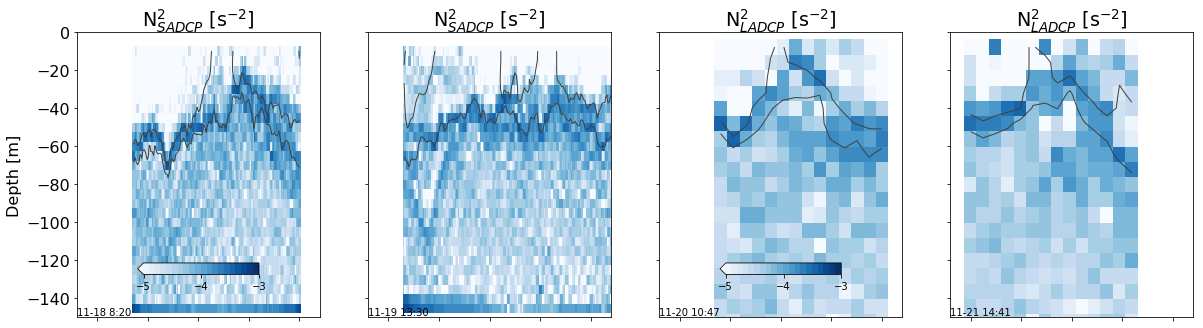

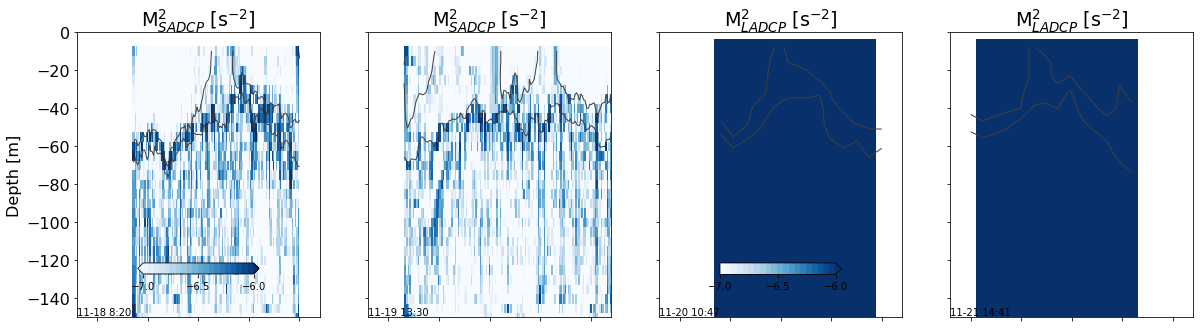

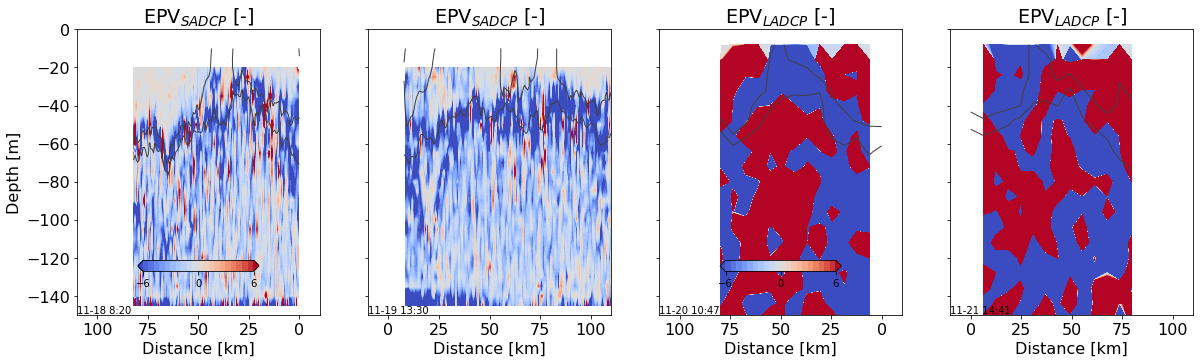

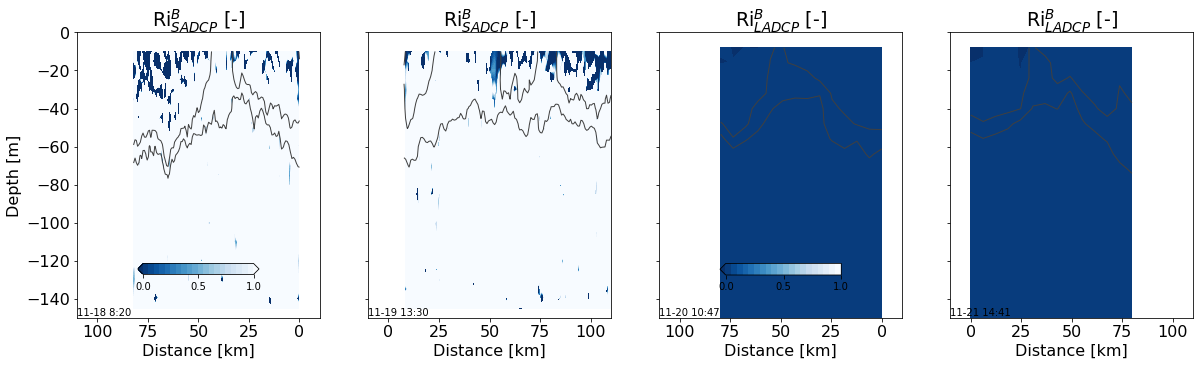

In [7]:
# map plots of cruise track, highlighting sections that are plotted below. 
# The background shows SST for the date in the upper right hand corner.
# The CTD station sections that are used below are highlighted in green, the Scanfish sections as thick grey lines
trans_ind = slice(0,2)
fg.plot_map_view(sadcp, ctd, glider_track, ladcp, scanfish, scan_sadcp[trans_ind], ctd_ladcp[trans_ind],
                              topo,sst_map,sst_map1,x_lim=[0,150])

# each call to plot_profile_view makes a row of plots for the variable "var_names"
# The dates in the lower left hand corners indicate the start of the section
# All colorbars are consistent for all instruments
# thin contour lines show density, trying to locate the filament approximately
x_lim = [-10,110]
var_names = list(('u',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('v',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('CT',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('sigma_0',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('db_dz_log10',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('db_dx_log10',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)

# plotting Ertel Potential Vorticity and balanced Richardson number; 
# resolution of LADCP/CTD data may be too coarse for db/dx and therefore Rib; Or is there another way to calculate it?!!?!?
# Where EPV > 0, instabilities may form; the type of Instability can be determined using Rib
var_names = list(('EPV_plot',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,last_row_flag=1)
var_names = list(('Rib',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,last_row_flag=1)



Looing at only the SADCP/Scanfish data, with a bit different layout

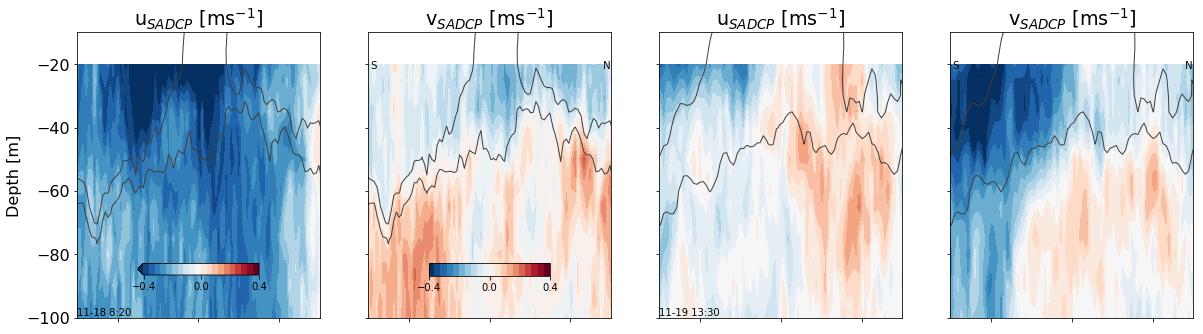

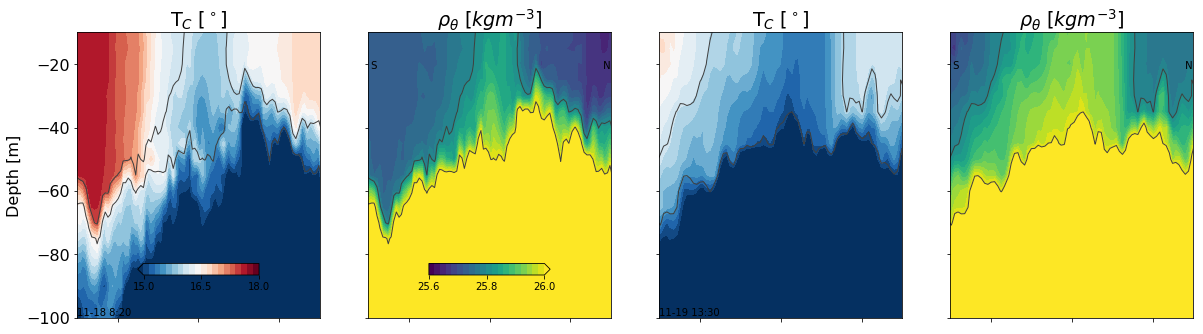

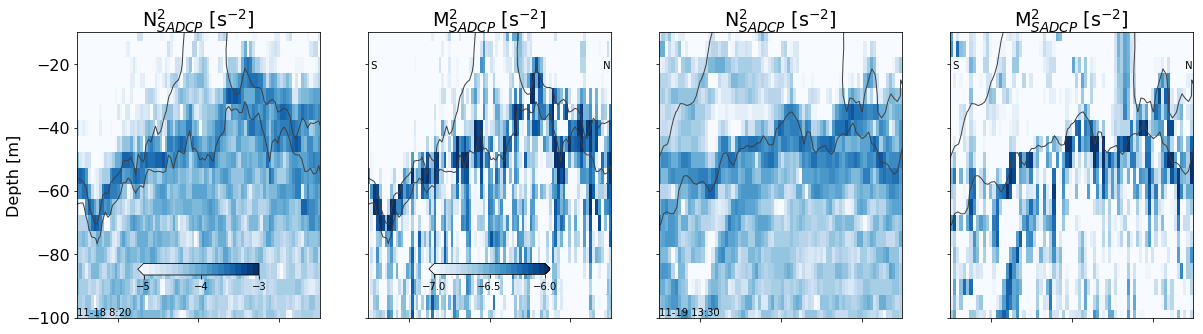

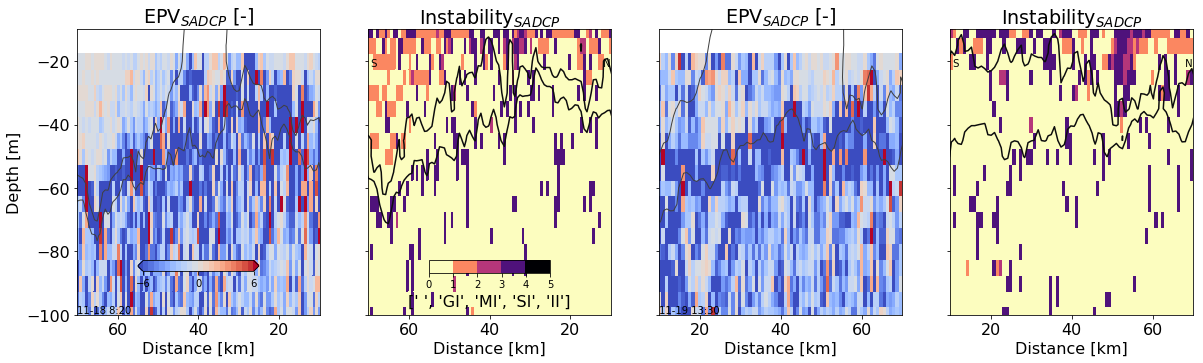

In [8]:
trans_ind = slice(0,2)
x_lim, y_lim = [10,70],  [-100,-10]

# The dates in the lower left hand corners indicate the start of the section
# All colorbars are consistent for all instruments
# each call to plot_profile_view plots the two variables of one section, followed by the same two variables of the next section
# thin contour lines show density, trying to locate the filament approximately
var_names = list(('u','v'))
fg.plot_profile_view(scan_sadcp[trans_ind], None, var_names, x_lim=x_lim,y_lim=y_lim)#,pcolormesh_flag=1)
var_names = list(('CT','sigma_0'))
fg.plot_profile_view(scan_sadcp[trans_ind], None, var_names, x_lim=x_lim,y_lim=y_lim)#,pcolormesh_flag=1)
var_names = list(('db_dz_log10','db_dx_log10'))
fg.plot_profile_view(scan_sadcp[trans_ind], None, var_names, x_lim=x_lim,y_lim=y_lim,pcolormesh_flag=1)

# plotting Ertel Potential Vorticity and balanced Richardson number; 
# resolution of LADCP/CTD data may be too coarse for db/dx and therefore Rib
# Where EPV > 0, instabilities may form; the type of Instability can be determined using Rib
# ==!!== Gravitational, Mixed (Grav and Sym), Symmetric, and eventually Inertial and Stable, but the last two are not yet setup
var_names = list(('EPV_plot','Instability_GravMixSymInertStab'))
fg.plot_profile_view(scan_sadcp[trans_ind], None, var_names, x_lim=x_lim,y_lim=y_lim,last_row_flag=1,pcolormesh_flag=1)


2nd Drifter station in upwelling region

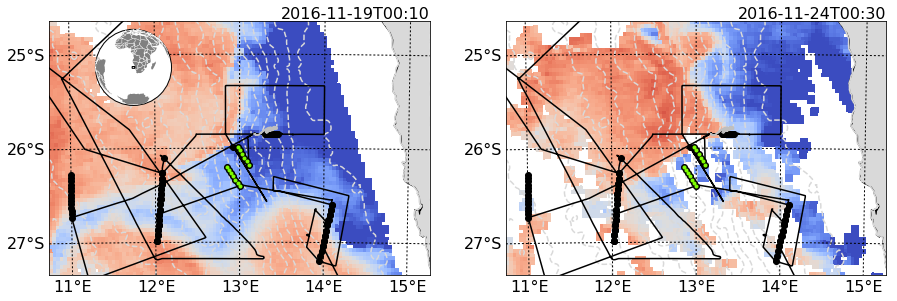

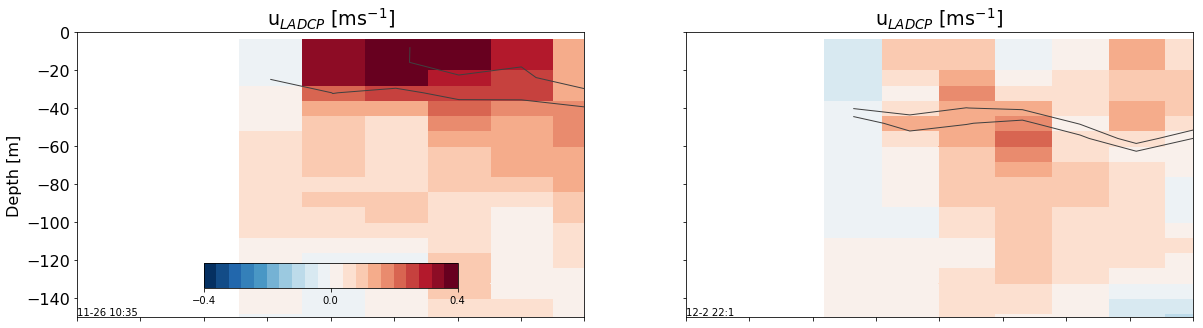

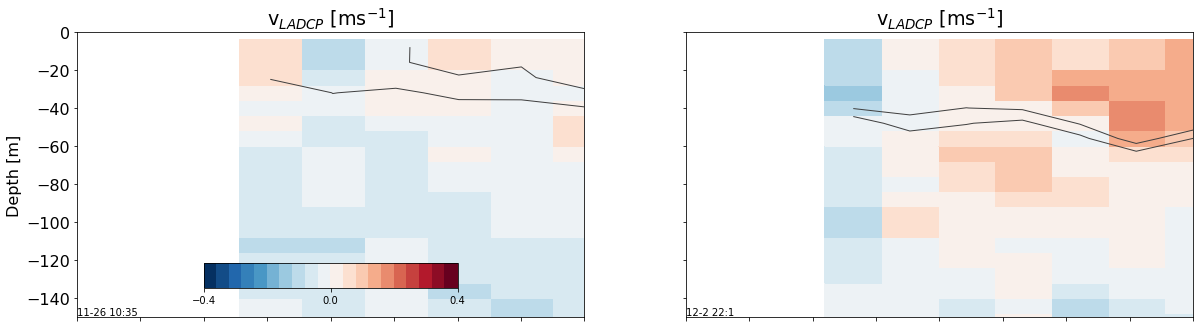

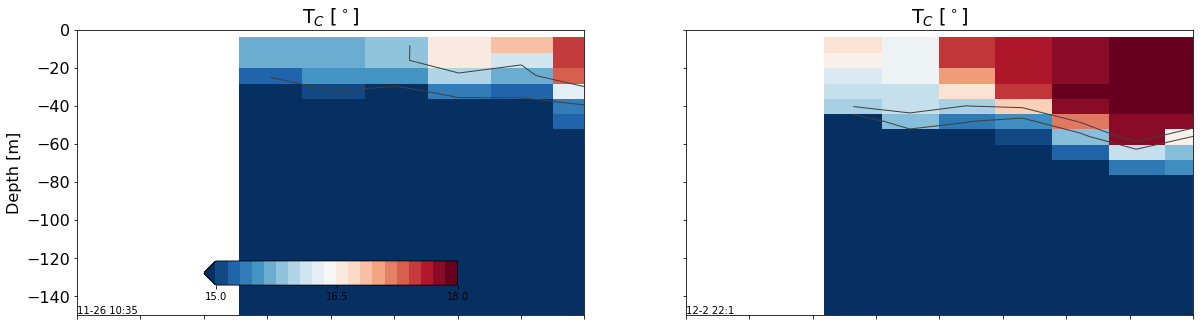

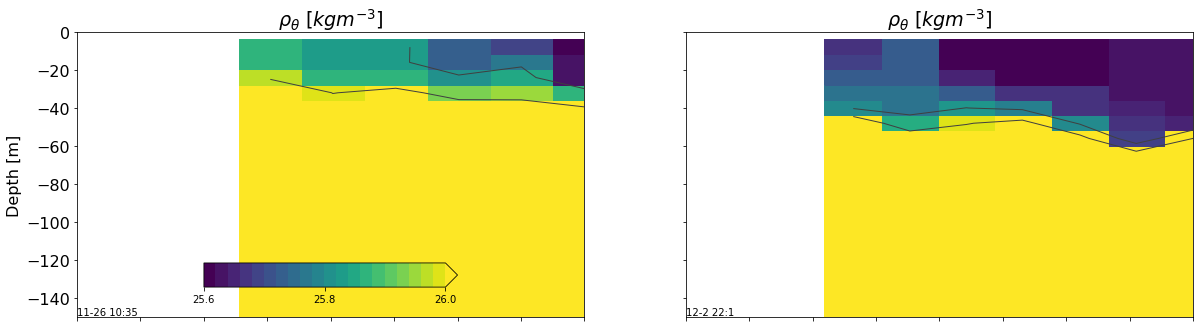

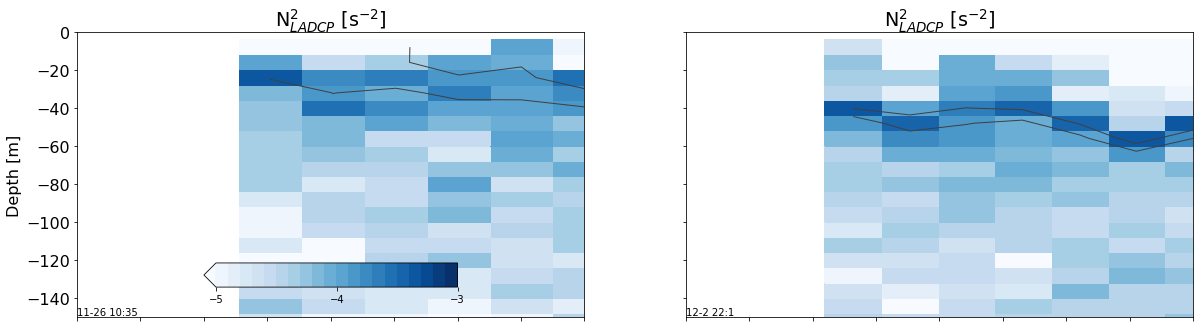

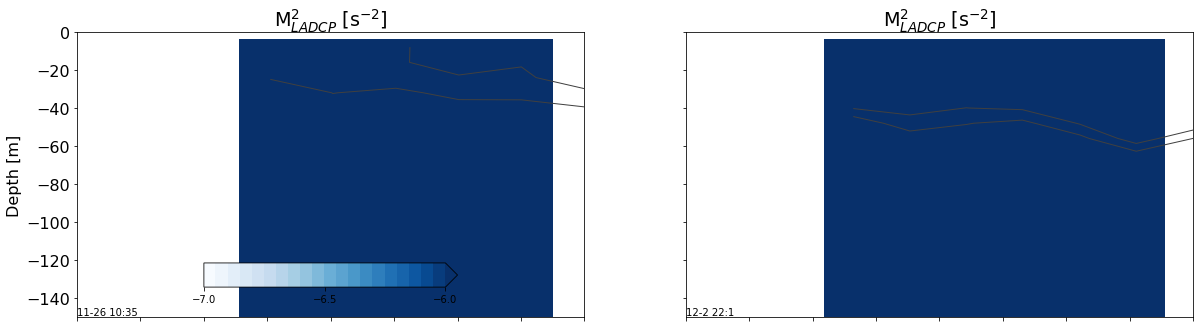

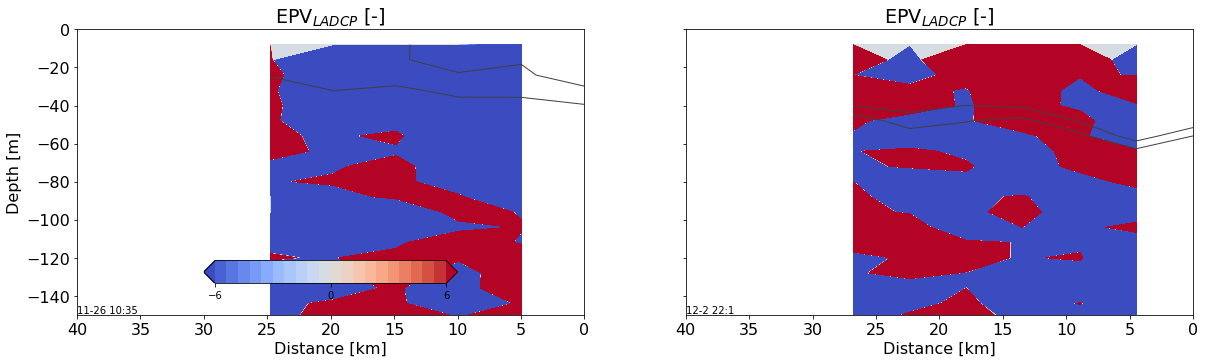

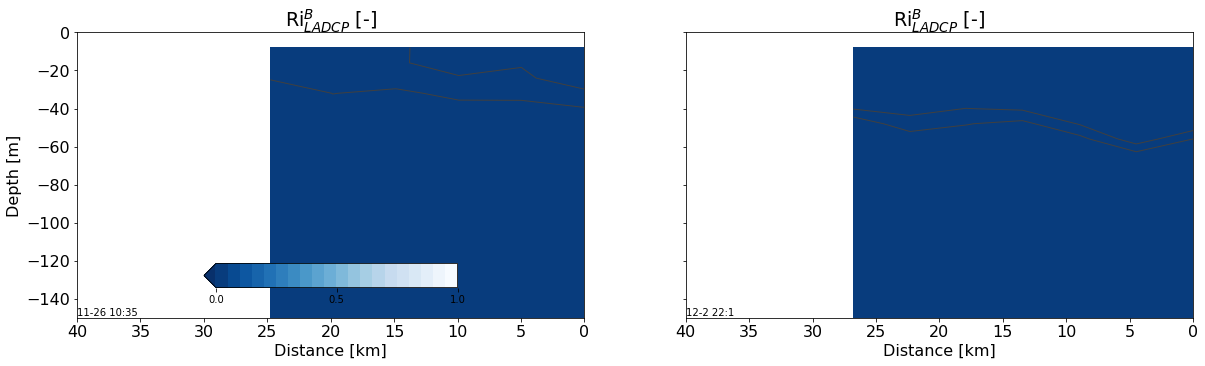

In [9]:
# map plots of cruise track, highlighting sections that are plotted below. 
# The background shows SST for the date in the upper right hand corner.
# The CTD station sections that are used below are highlighted in green, the Scanfish sections as thick grey lines
trans_ind = slice(3,5)
fg.plot_map_view(sadcp, ctd, glider_track, ladcp, scanfish, [], ctd_ladcp[trans_ind],
                 topo,sst_map,sst_map1,x_lim=[0,150])
 
# each call to plot_profile_view makes a row of plots for the variable "var_names"
# The dates in the lower left hand corners indicate the start of the section
# All colorbars are consistent for all instruments
# thin contour lines show density, trying to locate the filament approximately
x_lim = [0,40]
var_names = list(('u',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('v',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('CT',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('sigma_0',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('db_dz_log10',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('db_dx_log10',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)

# plotting Ertel Potential Vorticity and balanced Richardson number; 
# resolution of LADCP/CTD data may be too coarse for db/dx and therefore Rib; Or is there another way to calculate it?!!?!?
# Where EPV > 0, instabilities may form; the type of Instability can be determined using Rib
var_names = list(('EPV_plot',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,last_row_flag=1)
var_names = list(('Rib',''))
fg.plot_profile_view(scan_sadcp[trans_ind], ctd_ladcp[trans_ind], var_names, x_lim=x_lim,last_row_flag=1)


At one laocation, three CTD/LADCP sections were repeated; note that the third section is nearly 10 days later

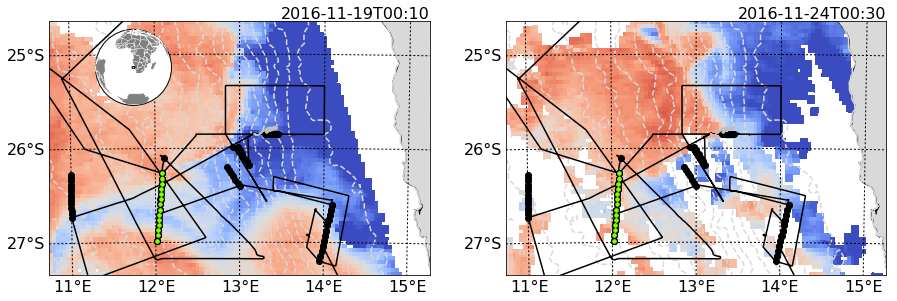

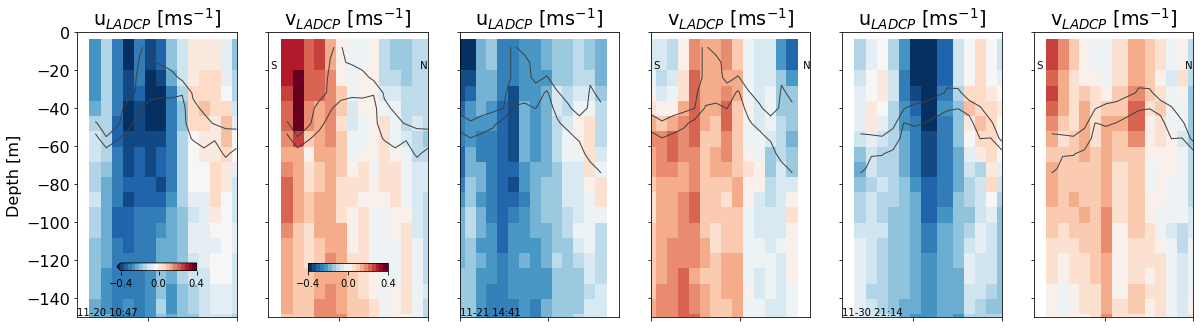

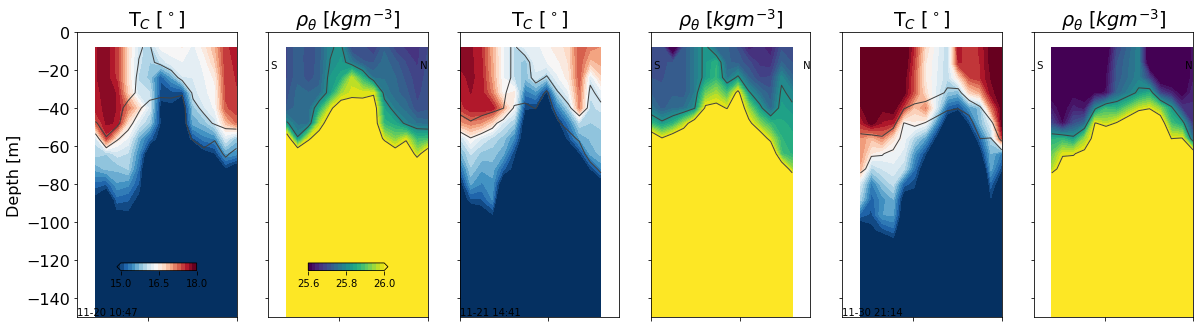

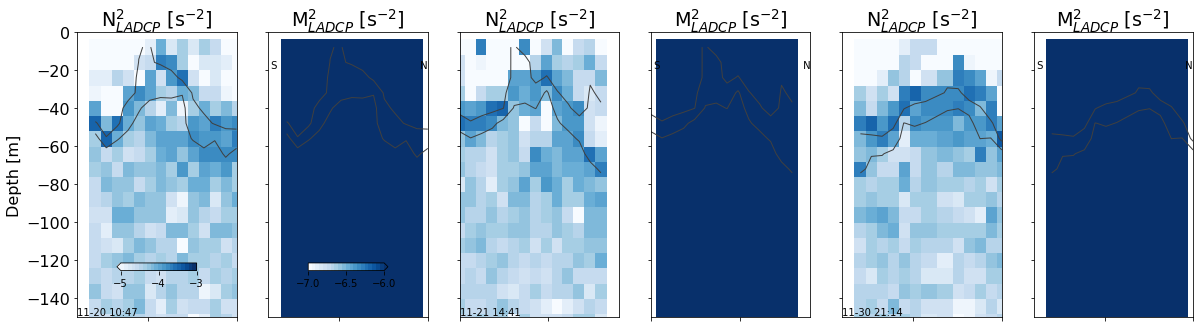

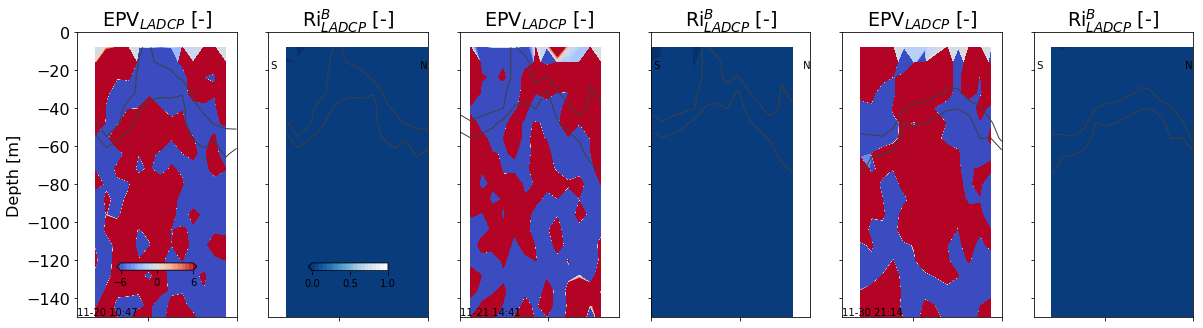

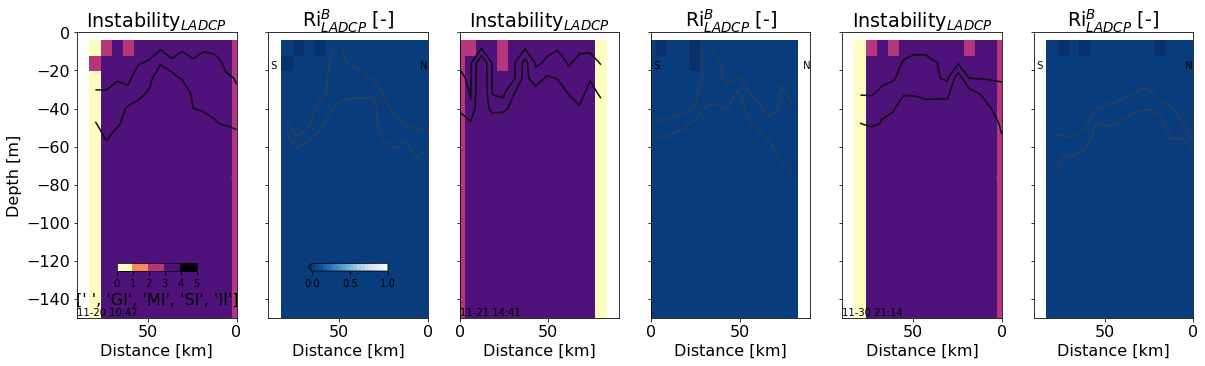

In [10]:
# map plots of cruise and sections
trans_ind = slice(0,3)
fg.plot_map_view(sadcp, ctd, glider_track, ladcp, scanfish, [], ctd_ladcp[trans_ind],
                              topo,sst_map,sst_map1,x_lim=[0,150])
 
# each call to plot_profile_view plots the two variables of one section, followed by the same two variables of the next section
# The dates in the lower left hand corners indicate the start of the section
# All colorbars are consistent for all instruments
# thin contour lines show density, trying to locate the filament approximately
x_lim = [0,90]
var_names = list(('u','v'))
fg.plot_profile_view(None, ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('CT','sigma_0'))
fg.plot_profile_view(None, ctd_ladcp[trans_ind], var_names, x_lim=x_lim)
var_names = list(('db_dz_log10','db_dx_log10'))
fg.plot_profile_view(None, ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1)
var_names = list(('EPV_plot','Rib'))
fg.plot_profile_view(None, ctd_ladcp[trans_ind], var_names, x_lim=x_lim)#,last_row_flag=1)
var_names = list(('Instability_GravMixSymInertStab','Rib'))
fg.plot_profile_view(None, ctd_ladcp[trans_ind], var_names, x_lim=x_lim,pcolormesh_flag=1,last_row_flag=1)


Running some tests to compare Contourf and Pcolormesh; 

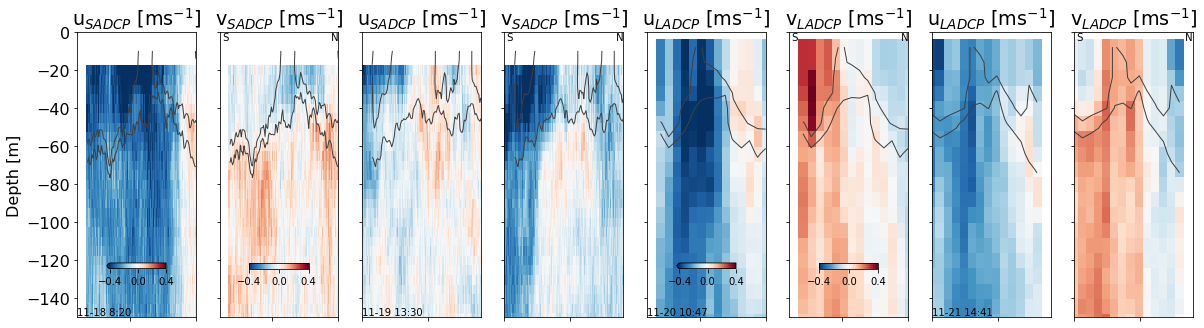

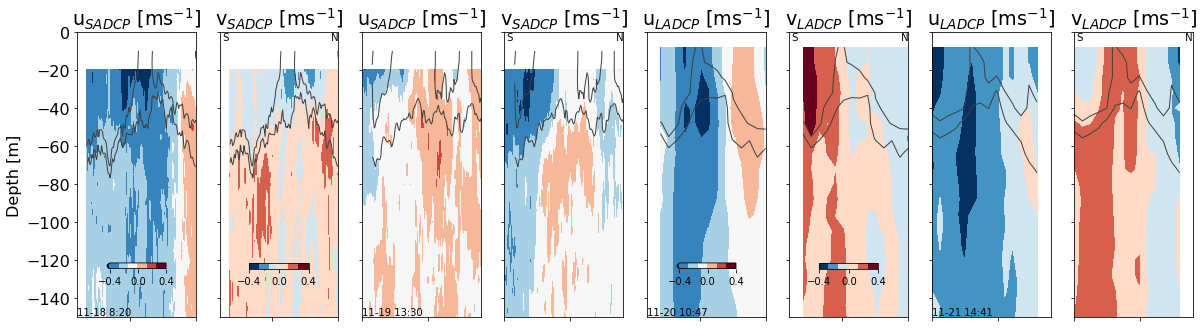

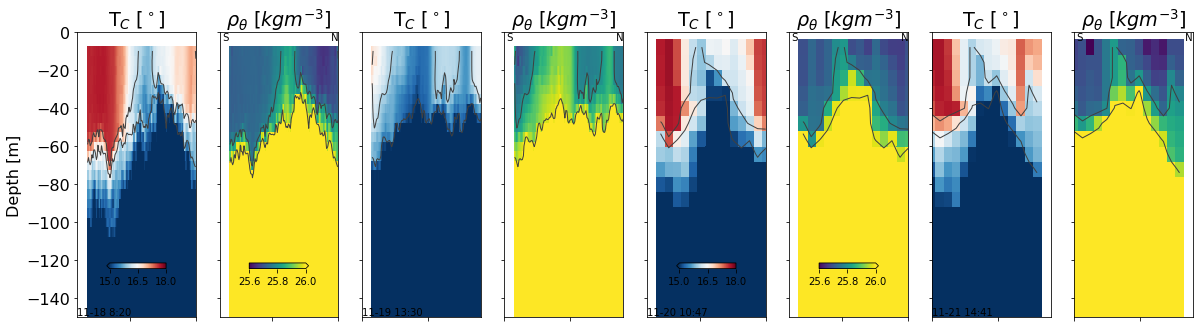

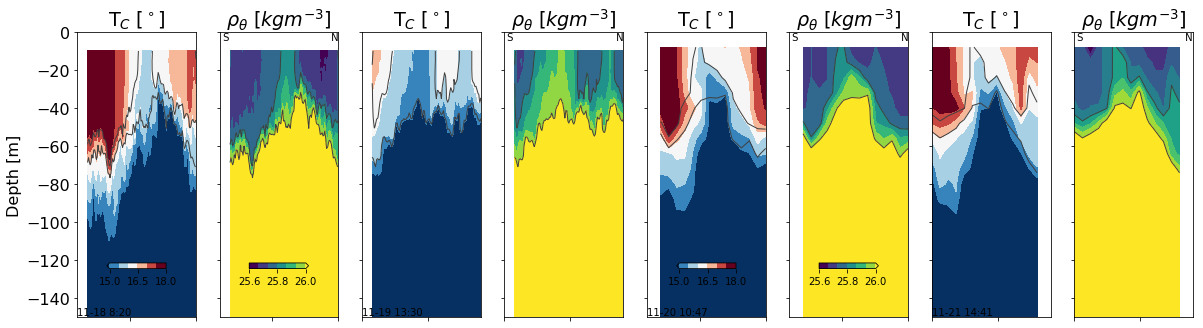

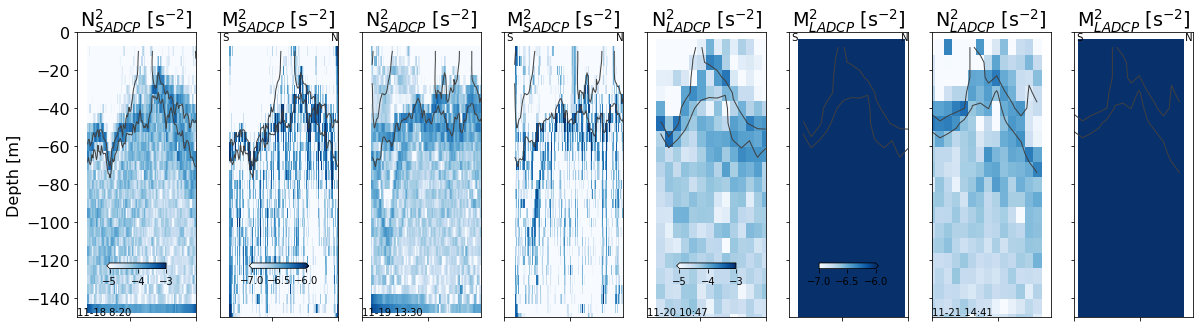

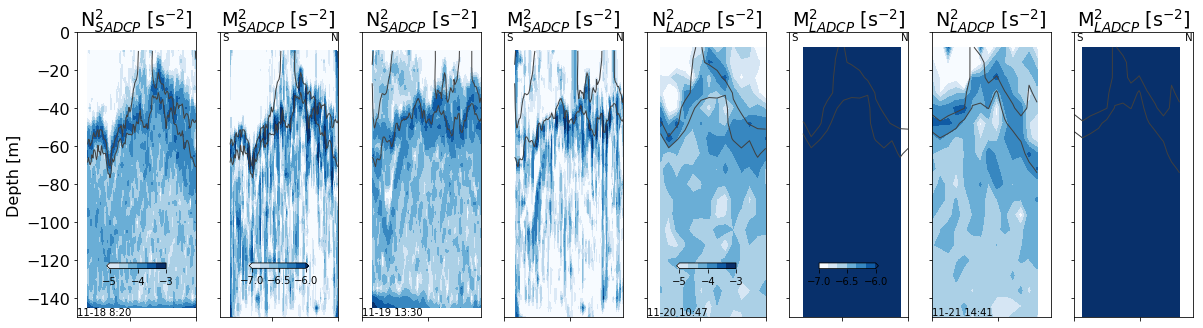

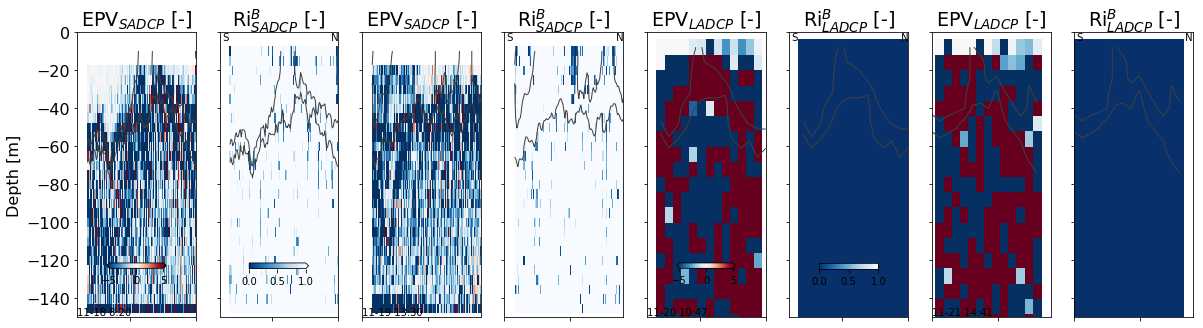

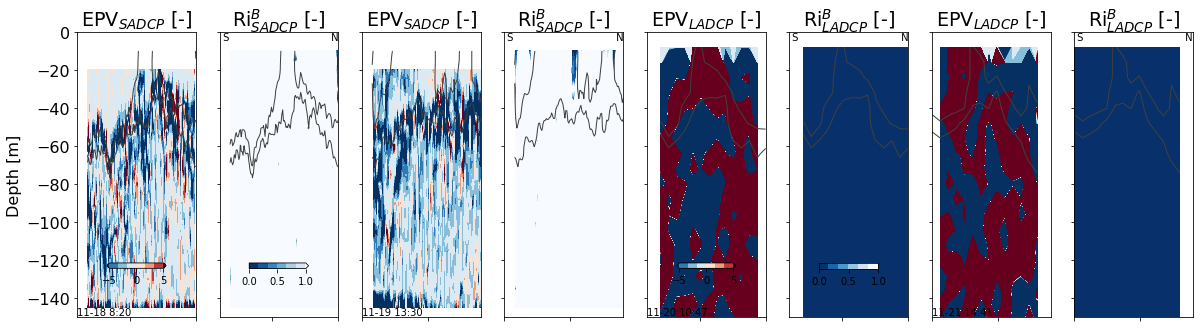

In [10]:
# map plots of cruise and sections

#fg.plot_map_view(sadcp, ctd, glider_track, ladcp, scanfish, scan_sadcp[0:2], ctd_ladcp[0:2],
#                              topo,sst_map,sst_map1,x_lim=[0,150])
 
x_lim = [0,90]
var_names = list(('u','v'))
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim,pcolormesh_flag=1)
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim)
var_names = list(('CT','sigma_0'))
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim,pcolormesh_flag=1)
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim)
var_names = list(('db_dz_log10','db_dx_log10'))
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim,pcolormesh_flag=1)
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim)
var_names = list(('EPV_plot','Rib'))
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim,pcolormesh_flag=1)
fg.plot_profile_view(scan_sadcp[0:2], ctd_ladcp[0:2], var_names, x_lim=x_lim)

